### Protein Grouping based on AlphaDIA output

Start from psm.tsv output & implement protein grouping:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Use the index of psm_table as peptide IDs for easier lookup; otherwise, the unique identifier for a precursor is the precursor_idx. Generate a dataframe `protein_table` with a `proteins` and  `peptides` column, where the latter contains sets of all peptides belonging to a certain protein. Generate a lookup list containing all peptide indices, and a boolean state vector of the same length to indicate whether this peptide has been taken by a protein. 

- 1.: Identify proteotypic precursors --> this has an issue for now, proteins apparently only contains protein ambiguity groups (e.g. isoforms)
- 2.: Merge all proteins in `protein_table` if their peptides are identical.
- 3.: Merge all proteins in `protein_table` into ambiguity groups if their peptides are subsets of each other
- 4.: Use greedy set cover to assign peptides to proteins by the razor principle & maximum parsimony

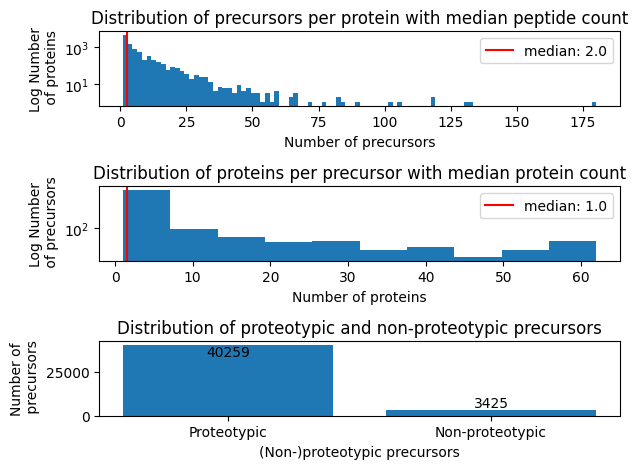

In [113]:
#retrieve psm.tsv output table
precursor_table = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t")

#Generate dataframe where each row is a protein and the peptides are in a set
protein_table = precursor_table.groupby("proteins").apply(lambda x : set(x.index)).reset_index(name = "peptides")
protein_table.sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Convert csv protein names to set
precursor_table["proteins_set"] = precursor_table.proteins.apply(lambda x : set(x.split(";")))
precursor_table.sort_values(by = "proteins_set", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Add proteotypicity column
precursor_table["proteotypic"] = precursor_table.proteins_set.apply(lambda x : len(x) == 1)

#visualize distribution of peptide counts per protein and proteins per peptide
fig, ax = plt.subplots(3, 1)
ax[0].hist(protein_table.peptides.str.len(), bins = 100, log = True)
ax[0].set_xlabel("Number of precursors")
ax[0].set_ylabel("Log Number\n of proteins")
ax[0].axvline(protein_table.peptides.str.len().median() + 0.5, color = "red", label = f"median: {protein_table.peptides.str.len().median()}")
ax[0].set_title("Distribution of precursors per protein with median peptide count")
ax[0].legend()
ax[1].hist(precursor_table.proteins_set.str.len(), bins = 10, log = True)
ax[1].set_xlabel("Number of proteins")
ax[1].set_ylabel("Log Number\n of precursors")
ax[1].axvline(precursor_table.proteins_set.str.len().median() + 0.5, color = "red", label = f"median: {precursor_table.proteins_set.str.len().median()}")
ax[1].set_title("Distribution of proteins per precursor with median protein count")
ax[1].legend()
ax[2].bar(["Proteotypic", "Non-proteotypic"], [precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())], log = False)
ax[2].set_title("Distribution of proteotypic and non-proteotypic precursors")
#label bars with counts
for i, v in enumerate([precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())]):
    alignment = ["top" if v > precursor_table.proteotypic.sum()/2 else "bottom"][0]
    ax[2].text(i, v, str(v), ha = "center", va = alignment)
ax[2].set_xlabel("(Non-)proteotypic precursors")
ax[2].set_ylabel("Number of\n precursors")
fig.tight_layout()

plt.show()

In [ ]:
#rewrite protein grouping

In [584]:

def split_targets_decoys(
        precursor_table: pd.DataFrame,
):
    return (
        precursor_table[precursor_table["_decoy"] == 0],
        precursor_table[precursor_table["_decoy"] == 1]
    )

def transform_to_precursor_dict(
        precursor_table: pd.DataFrame,
        subset_columns: list,
):
    """Utility for
        - subset columns per input list
        - convert proteins column into sets of proteins
    
    Args:
        precursor_table: PSM table (e.g. psm.tsv from AlphaDIA)
        column_list: list of column names to extract
    """
    precursor_dict = precursor_table.to_dict(orient = 'list')

    precursor_dict_subset = {}
    for k, v in precursor_dict.items():
        if k in subset_columns:
            precursor_dict_subset[k] = v

    precursor_dict_subset["proteins_set"] = [set(s.split(";")) for s in precursor_dict_subset["proteins"]]

    return precursor_dict_subset

def collapse_identical_precursors(
        precursor_dict: dict,
):
    """Utility for collapsing precursor rows: 
    If n runs are processed, the same precursor_idx occurs n times. The purpose of this function is to collapse these rows into one"""

    if "precursor_idx" not in precursor_dict.keys():
        raise ValueError("Input dataset does not contain 'precursor_idx' column")
    if "proteins_set" not in precursor_dict.keys():
        raise ValueError("Input dataset does not contain 'proteins_set' column")
        
    carryover_keys = [key for key in precursor_dict.keys() if key not in ["precursor_idx","proteins_set"]]
    carryover_dict = {key: precursor_dict[key] for key in carryover_keys}
    carryover_values = list(carryover_dict.values())

    collapsed_precursor_dict = {}
    for precursor_idx, proteins_set in zip(precursor_dict['precursor_idx'], precursor_dict["proteins_set"]):
        if precursor_idx not in collapsed_precursor_dict.keys():
            collapsed_precursor_dict[precursor_idx] = proteins_set
        else:
            pass

    collapsed_precursor_dict = {
        'precursor_idx': list(collapsed_precursor_dict.keys()),
        'proteins_set': list(collapsed_precursor_dict.values())
    }

    return collapsed_precursor_dict

def get_protein_longtable(
        precursor_dict: dict,
):
    """Utility for transforming a precursor table (psm_table) into a protein table.
    Example: transforming a table like this:

    | precursor_id | proteins_set |
    |--------------|--------------|
    | 1            | A;B          |
    | 2            | A;C          |
    | 3            | D            |

    Into a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | 1        |
    | A          | 2        |
    | B          | 1        |
    | C          | 2        |
    | D          | 3        |
    
    Args:
        precursor_table: PSM table with target/decoy column.
    """
        
    protein_dict = {"protein_id": [], "peptide": []}
    for i, protein_set in zip(precursor_dict["precursor_idx"], precursor_dict["proteins_set"]):
        for protein in protein_set:
            protein_dict["protein_id"].append(protein)
            protein_dict["peptide"].append(i)

    return protein_dict

def collapse_protein_longtable(
        protein_longtable: dict,
):
    """Utility for transforming a long protein - peptide table into a short protein table.
    Example: transforming a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | 1        |
    | A          | 2        |
    | B          | 1        |
    | C          | 2        |
    | D          | 3        |

    Into a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | 1;2      |
    | B          | 1        |
    | C          | 2        |
    | D          | 3        |

    
    Args:
        precursor_table: PSM table with target/decoy column.
    """

    #collapse into unique proteins with sets of associated peptides:
    protein_ids = []
    peptide_sets = []
    for prot, pep in zip(protein_longtable["protein_id"], protein_longtable["peptide"]):
        if prot not in protein_ids:
            protein_ids.append(prot)
            peptide_sets.append(set([pep]))
        else:
            peptide_sets[protein_ids.index(prot)].add(pep)
    collapsed_protein_dict = {
        "protein_id": protein_ids,
        "peptide_set": peptide_sets 
    }

    return collapsed_protein_dict

def group_proteins(
        protein_dict: dict,
):
    """Group proteins based on peptide sets.
    Example: transforming a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | {1;2}    |
    | B          | {1}      |
    | C          | {2}      |
    | D          | {2;3}    |

    Into a table like this:

    | protein_ids | peptides           |
    |-------------|--------------------|
    | [A,B,C]     | [{1;2},{1},{2}]    |
    | [C,D]       | [{2};{2;3}]        |

    RAZOR PEPTIDES: Peptide 2 is a razor peptide and also provides evidence for protein C. Therefore peptide 2 as well as protein C are assigned to all groups that claim peptide 2. 
    This has to be resolved with maximum parsimony later. Resolving razors later necessitates that we keep track of which protein "contributed" which peptide set.

    Args:
        protein_dict: A dictionary with a unique protein_id column and a peptide_set column
    """

    #pseudocode

    #convert protein_dict columns to arrays
    #use index based ordering to order by peptide set length
    #make empty global proteins list and empty global peptide sets list
    #loop over peptide sets
    #   make empty proteins list and empty peptide sets list
    #   append current peptide set and current protein_id to respective lists
    #   inner loop:
    #       iterate over all peptide sets below the query set and check if they are a subset or identical to the query set
    #       if they are, add their peptide set to peptider sets list and their protein id to proteins list
    #NO REMOVING JUST NOW --> these are preliminary, greedy groups that must be folded into each other later & have their razor peptides resolved

    protein_ids = np.array(protein_dict["protein_id"])
    protein_index = np.arange(len(protein_ids))
    peptide_sets = np.array(protein_dict["peptide_set"])
    peptide_set_lengths = np.array([len(x) for x in peptide_sets])

    #sort by peptide_set_lengths
    sort_idx = np.argsort(peptide_set_lengths)[::-1]
    protein_ids = protein_ids[sort_idx]
    peptide_sets = peptide_sets[sort_idx]
    peptide_set_lengths = peptide_set_lengths[sort_idx]

    #starting from the protein with most peptides, iterate all shorter or equally long ones and create greedy groups
    #NO COLLAPSING IDENTICALS HERE, continue with redundant groups for now but record unique counts for peptides and proteins
    global_protein_group = []
    global_peptide_sets = []
    global_unique_peptide_set = []
    global_unique_peptide_set_len = []
    global_unique_group_len = []

    for i, query_id, query_set in zip(protein_index, protein_ids, peptide_sets):
        local_protein_ids = [query_id]
        local_peptide_sets = [query_set]
        for n, subject_id, subject_set in zip(protein_index[i+1:], protein_ids[i+1:], peptide_sets[i+1:]):
            if subject_set.issubset(query_set):
                local_protein_ids.append(subject_id)
                local_peptide_sets.append(subject_set)

        global_protein_group.append(local_protein_ids)
        global_peptide_sets.append(local_peptide_sets)
        unique_peptides = set().union(*local_peptide_sets)
        global_unique_peptide_set.append(unique_peptides)
        global_unique_peptide_set_len.append(len(unique_peptides))
        global_unique_group_len.append(len(np.unique(local_protein_ids)))

    #sort again by unique peptide count
    return({
        "protein_group": global_protein_group, 
        "peptide_sets": global_peptide_sets, 
        "unique_peptide_set": global_unique_peptide_set, 
        "unique_peptide_set_len": global_unique_peptide_set_len,
        "unique_group_len": global_unique_group_len
    })


def apply_parsimony(
        protein_dict: dict,
        strict_parsimony = True,
):
    """Strict parsimony to decide which peptides and proteins to keep for a protein group:
    
    Args:
        protein_dict: A dictionary with a global_protein_groups (list of str) and a peptide_set (list of set) column
        strict_parsimony: If True, every peptide is used exactly once and razor peptides are assigned to the largest group. Greedy Set cover is used for grouping.
    """

    if not strict_parsimony:
        raise NotImplementedError

    #pseudocode

    #extract arrays from input dict
    #greedy set cover: order peptides by overall unique peptide set length
    #loop: for each group
    #   

    #continue with numpy/numba implementation:
    protein_group = protein_dict["protein_group"]
    peptide_sets = protein_dict["peptide_sets"]
    unique_peptide_set = protein_dict["unique_peptide_set"]
    unique_peptide_set_len = protein_dict["unique_peptide_set_len"]
    unique_group_len = protein_dict["unique_group_len"]

    #order by unique peptide set length
    sort_idx = np.argsort(unique_peptide_set_len)[::-1]
    protein_group = [protein_group[i] for i in sort_idx]
    peptide_sets = [peptide_sets[i] for i in sort_idx]
    unique_peptide_set = [unique_peptide_set[i] for i in sort_idx]
    unique_peptide_set_len = [unique_peptide_set_len[i] for i in sort_idx]
    unique_group_len = [unique_group_len[i] for i in sort_idx]
    
    #greedy set cover implementation for razor principle:
    available_peptides = np.fromiter(set().union(*unique_peptide_set), dtype = np.int64, count = -1)
    available_peptides_status = np.ones(len(available_peptides), dtype = bool)

    #iterate over peptide_sets and set lookup to zero where all_peptides matches peptide_set
    new_groups = {}
    for i, query_group, query_peptides in zip(np.arange(len(protein_group)), protein_group, unique_peptide_set):
        if query_peptides is None:
            continue
        query_peptides = np.fromiter(query_peptides, dtype = np.int64, count = -1)
        keep_peptides = query_peptides[available_peptides_status[query_peptides]]
        new_groups[str(query_group)] = keep_peptides

        #update status of available peptides
        available_peptides_status[keep_peptides] = False

        #update every peptide set in unique_peptide_set, recompute unique_peptide_set_len and reorder
        for pep in keep_peptides:
            for n, peptide_set in enumerate(unique_peptide_set[i+1:]):
                print(peptide_set)
                if peptide_set is not None and pep in peptide_set:
                    unique_peptide_set[n] = peptide_set.remove(pep)
            unique_peptide_set_len[n] = len(peptide_set)

        #reorder before next iteration
        sort_idx = np.argsort(unique_peptide_set_len)[::-1]
        protein_group = [protein_group[i] for i in sort_idx]
        peptide_sets = [peptide_sets[i] for i in sort_idx]
        unique_peptide_set = [unique_peptide_set[i] for i in sort_idx]
        unique_peptide_set_len = [unique_peptide_set_len[i] for i in sort_idx]
        unique_group_len = [unique_group_len[i] for i in sort_idx]

    return new_groups
        


In [423]:
#add two boolean np arrays

for i in enumerate(np.array([1,2,3,4])):
    print(i)

(0, 1)
(1, 2)
(2, 3)
(3, 4)


In [585]:
#sample data:
import pandas as pd
precursor_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
proba = [x / (x + 10) for x in precursor_idx]

df = pd.DataFrame({
    "precursor_idx": precursor_idx,
    "proteins": ['P1;P2;P3;P4', 'P1;P2;P3;P4', 'P1;P2', 'P1;P2', 'P4', 'P4', 'P4;P5', 'P4;P5', 'P6', 'P6'],
    "_decoy": [0,0,0,0,0,0,0,0,1,1],
    "proba": proba
})
display(df)

print("subset targets:")
targets, decoys = split_targets_decoys(df)
#display(pd.DataFrame(targets))

print("convert to dictionary and add protein sets:")
ds = transform_to_precursor_dict(targets, subset_columns = ["precursor_idx", "proteins", "proba"])
#display(pd.DataFrame(ds))

print("collapse identical precursors which could originate from multiple runs:")
ds = collapse_identical_precursors(ds)
#display(pd.DataFrame(ds))

print("elongate to get protein table:")
ds = get_protein_longtable(ds)
#display(pd.DataFrame(ds))

print("collapse protein longtable and get peptide sets. Notice how P1 and P2 have the exact same peptide set")
ds = collapse_protein_longtable(ds)
display(pd.DataFrame(ds))

print("apply protein grouping in a greedy manner: proteins and peptides can belong to multiple groups")
ds = group_proteins(ds)
display(pd.DataFrame(ds))

print("apply strict parsimony for grouping")
ds = apply_parsimony(ds)
print(ds)

,precursor_idx,proteins,_decoy,proba
0,0,P1;P2;P3;P4,0,0.000000
1,0,P1;P2;P3;P4,0,0.000000
2,1,P1;P2,0,0.090909
3,1,P1;P2,0,0.090909
4,2,P4,0,0.166667
5,2,P4,0,0.166667
6,3,P4;P5,0,0.230769
7,3,P4;P5,0,0.230769
8,4,P6,1,0.285714
9,4,P6,1,0.285714


subset targets:
convert to dictionary and add protein sets:
collapse identical precursors which could originate from multiple runs:
elongate to get protein table:
collapse protein longtable and get peptide sets. Notice how P1 and P2 have the exact same peptide set


,protein_id,peptide_set
0,P4,"{0, 2, 3}"
1,P2,"{0, 1}"
2,P1,"{0, 1}"
3,P3,{0}
4,P5,{3}


apply protein grouping in a greedy manner: proteins and peptides can belong to multiple groups


,protein_group,peptide_sets,unique_peptide_set,unique_peptide_set_len,unique_group_len
0,"[P4, P5, P3]","[{0, 2, 3}, {3}, {0}]","{0, 2, 3}",3,3
1,"[P1, P2, P3]","[{0, 1}, {0, 1}, {0}]","{0, 1}",2,3
2,"[P2, P3]","[{0, 1}, {0}]","{0, 1}",2,2
3,[P5],[{3}],{3},1,1
4,[P3],[{0}],{0},1,1


apply strict parsimony for grouping
{0, 1}
{0, 1}
{0}
{3}
None
None
set()
{3}
None
None
set()
{3}
{"['P4', 'P5', 'P3']": array([0, 2, 3]), "['P5']": array([], dtype=int64)}


Consider the example below. P3 is a subset of P1;P2, therefore the group is P1;P2;P3. P5 and P4 form a group because P5 is a subset of P5, and P3 is also a subset of them --> P1;P2;P3 = {1,2} and P4;P3;P5 = {1,4}
This is an issue, because 1 is a razor peptide and P3 only has peptide 1 as evidence. The protein groups must be resolved same as razor peptide.
It is clear that peptide 1 is a razor peptide that could belong to either P1;P2;P3 or P4;P3;P5. Assignment hierarchy works as follows: razor to group with more peptides; if same amount of peptides: razor to group with more proteins; if same amount of proteins: random*
*must be replaced with e.g. intensity, mass accuracy, score, etc. etc. 

P1;P2;P3 - {1,2}
P4;P3;P5 - {1,4}

These are large groups prior to applying maximum parsimony via greedy set cover, after deciding who gets the razor peptide 1 (in this case for example the first group). Note that P3 must also be removed from the second group

P1;P2;P3 - {1,2}
P4;P5 - {4}

This sorts the quantification as well. Edge cases need to be examined in detail per "Interpretation of Shotgun Proteomics Data" by Nesvizhskii et al. 2005 --> distinct, differentiable(overlapping), indistinguishable(identical), subset, subsumable, cyclic

In [194]:
#load psm table data
precursor_table = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t").iloc[:10,::]
#get targets
targets, decoys = split_targets_decoys(precursor_table)
#convert to dictionary
ds = precursor_table_to_dict(targets)
#extract the columns necessary for grouping and rename if necessary
ds = transform_precursor_dict(ds, ["precursor_idx", "proteins"])
#collapse identical precursor
ds = collapse_identical_precursors(ds)
#elongate to get protein table
get_protein_table(ds)

{'protein_id': ['P16521',
  'P38011',
  'P33331',
  'P14540',
  'P05759',
  'Q06146',
  'Q06682',
  'Q64436',
  'Q8VDN2',
  'Q6PIE5',
  'Q6PIC6',
  'Q61165',
  'Q8R1Q8'],
 'peptide_set': [{124703},
  {175743},
  {165493},
  {118869},
  {97538},
  {274712},
  {277037},
  {359355},
  {359355},
  {359355},
  {359355},
  {334967},
  {437502}]}

In [13]:
def strict_protein_grouping(
    precursor_table: pd.DataFrame,
    graphical_output: bool = False
    ):

    """Function to perform parsimonious protein grouping
    Args:
        precursor_table: long table where rows are precursors with continuous indices and a "proteins" column contains semicolon-separated strings of protein names
    """

    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    if graphical_output:
        raise NotImplementedError("Graphical output not implemented yet")

    #exclude decoys
    precursor_table = precursor_table[precursor_table.decoy == 0]
    precursor_table = precursor_table.reset_index(drop = True)

    #Record proteotypic precursors
    precursor_table["protein_set"] = precursor_table.proteins.apply(lambda x : set(x.split(";")))
    precursor_table = precursor_table.sort_values(by = "protein_set", key = lambda x : x.str.len(), ascending = False)
    
    precursor_table["proteotypic"] = precursor_table.protein_set.apply(lambda x : len(x) == 1)
    
    #compile set of all peptide indices & create lookup array for peptide indices
    peptide_indices = set(precursor_table.index)
    peptide_lookup = np.ones(len(peptide_indices), dtype = bool)

    #protein dataframe: repeated rows for each protein that belongs to a peptide
    protein_table = {"protein": [], "peptide": []}
    for i, row in precursor_table.iterrows():
        peptide_index = i
        proteins = row["protein_set"]
        for protein in proteins:
            protein_table["peptide"].append(peptide_index)
            protein_table["protein"].append(protein)
    protein_table = pd.DataFrame(protein_table).groupby("protein").apply(lambda x : set(x.peptide)).reset_index(name = "peptides")
    display(protein_table.head())
    
    #GROUPING: summarize proteins with identical peptide sets into protein groups and remove duplicated rows --> now, each row is a protein group
    protein_table["peptide_set_string"] = protein_table.peptides.apply(lambda x : ";".join([str(i) for i in sorted(list(x))]))
    protein_table["protein"] = protein_table.groupby("peptide_set_string")["protein"].transform(lambda x : ";".join(x))
    protein_table = protein_table.drop_duplicates(subset = "protein").reset_index(drop = True)

    #Iterate over protein_table and remove peptides from lookup array as they are assigned to a new group
    new_protein_table = {}
    with tqdm(total = protein_table.shape[0]) as pbar:
        pbar.set_description("Protein grouping")
        for i in range(protein_table.shape[0]):    
            #check lookup array if current query peptides are taken & update lookup array & save new group
            query_protein = protein_table.iloc[0]["protein"]
            query_peptides = np.array(list(protein_table.iloc[0]["peptides"]), dtype = np.int64)

            keep_peptides = query_peptides[peptide_lookup[query_peptides]]
            peptide_lookup[keep_peptides] = False
            new_protein_table[query_protein] = keep_peptides

            #costly updating part: update each set in protein_table[peptides] to remove peptide indices that are in keep_set & resort
            protein_table.peptides = protein_table.peptides.apply(lambda x : set(x).difference(set(keep_peptides)))
            protein_table = protein_table.sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False)

            #update progress bar
            pbar.update(1)
    
    #convert new_protein_table to dataframe
    new_protein_table = pd.DataFrame({
        "protein": list(new_protein_table.keys()),
        "peptides": list(new_protein_table.values())
    }).sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False)
    return new_protein_table, protein_table


### To demonstrate how grouping would cut down peptide numbers per protein, generate sample data based on psm_tsv:

In [17]:
example_data = precursor_table.iloc[15:25]
display(example_data)
new_groups, old_groups = strict_protein_grouping(example_data)
display(new_groups)
display(old_groups)

,base_width_mobility,base_width_rt,rt_observed,mobility_observed,mono_ms1_intensity,top_ms1_intensity,sum_ms1_intensity,weighted_ms1_intensity,weighted_mass_deviation,weighted_mass_error,...,flat_frag_start_idx,channel,i_2,mz_library,_decoy,proba,qval,run,proteins_set,proteotypic
1506,0.0,23.970581,1127.8000,0.000001,30674140.0,28624760.0,76363016.0,23681004.0,-1.012363,1.012363,...,751097,0,0.195974,1037.96730,0.0,0.000232,0.000000,HF_20210523_M300-Y700_DIA_3,"{P0CX68, Q92392, Q12269, O74302, Q07793, P0C2J...",False
22788,0.0,23.386230,2571.4514,0.000001,6891310.0,6891310.0,10071504.0,4418660.5,0.584066,0.584066,...,750896,0,0.118850,584.31710,0.0,0.003806,0.000219,HF_20210523_M300-Y700_DIA_3,"{O13527, Q12269, Q12491, Q07793, Q12472, P0C2J...",False
3493,0.0,19.308594,5763.0435,0.000001,3617750.0,3617750.0,6780191.5,2445120.0,-0.307012,0.307012,...,750979,0,0.163324,720.41815,0.0,0.000346,0.000000,HF_20210523_M300-Y700_DIA_3,"{O13527, Q12269, Q12491, Q12472, P0C2J1, P0C2I...",False
13550,0.0,19.308594,5763.0435,0.000001,4123652.5,4123652.5,9415379.0,3273456.5,0.426561,0.426561,...,750843,0,0.163324,480.61453,0.0,0.001197,0.000000,HF_20210523_M300-Y700_DIA_3,"{O13527, Q12269, Q12491, Q12472, P0C2J1, P0C2I...",False
40894,0.0,14.875977,4548.8440,0.000001,1940298.5,1940298.5,3880522.8,1338437.1,0.039041,0.039041,...,750861,0,0.175851,523.31287,0.0,0.057450,0.006067,HF_20210523_M300-Y700_DIA_3,"{O13527, Q12269, Q12491, Q12472, P0C2J1, P0C2I...",False
11396,0.0,23.566406,3956.7622,0.000001,36500000.0,36500000.0,54925410.0,27128842.0,0.564887,0.564887,...,615939,0,0.079579,431.74270,0.0,0.000928,0.000000,HF_20210523_M300-Y700_DIA_3,"{Q8W4P1, P30285, P11440, Q3V3A1, Q64261, P2410...",False
6417,0.0,40.793457,4219.3037,0.000001,12761297.0,12761297.0,20267074.0,9086100.0,-1.677148,1.677148,...,750873,0,0.108809,550.32153,0.0,0.000523,0.000000,HF_20210523_M300-Y700_DIA_3,"{Q12269, Q12491, Q07793, Q12472, P0C2I7, P0C2I...",False
8172,0.0,28.307129,5635.3520,0.000001,14072668.0,14072668.0,20530678.0,9915122.0,0.137641,0.137641,...,677200,0,0.102647,437.75696,0.0,0.000643,0.000000,HF_20210523_M300-Y700_DIA_3,"{Q94F47, A0A2H1ZEG2, Q94A97, P35131, P15731, P...",False
18438,0.0,27.476318,3829.7273,0.000001,82416670.0,82416670.0,129769660.0,58682996.0,0.285836,0.285836,...,689199,0,0.109261,476.23947,0.0,0.002162,0.000054,HF_20210523_M300-Y700_DIA_3,"{Q39023, A0A1I9LRW2, Q39026, Q39027, A0A1P8B0K...",False
23088,0.0,19.642578,4585.7440,0.000001,7400237.0,7400237.0,15669067.0,5615417.0,0.916623,0.916623,...,750985,0,0.149679,726.39070,0.0,0.003952,0.000250,HF_20210523_M300-Y700_DIA_3,"{O13527, Q12269, Q07793, P0C2J1, P0C2I7, P0C2I...",False


,protein,peptides
0,A0A178UM63,{5}
1,A0A1I9LRW0,{8}
2,A0A1I9LRW1,{8}
3,A0A1I9LRW2,{8}
4,A0A1P8ARI0,{7}


  0%|          | 0/11 [00:00<?, ?it/s]

Protein grouping: 100%|██████████| 11/11 [00:00<00:00, 2647.31it/s]


,protein,peptides
1,O13535;P0C2I2;P0C2I5;P0C2I7;P0C2I9;P0C2J0;P471...,"[0, 1, 2, 3, 4, 6, 9]"
0,A0A178UM63;A0A1P8AWI5;A0A1P8BEB1;A0A1P8BEB2;A0...,[5]
2,A0A1I9LRW0;A0A1I9LRW1;A0A1I9LRW2;A0A1P8B0K7;F4...,[8]
3,A0A1P8ARI0;A0A2H1ZE82;A0A2H1ZEG2;F4I5B8;F4I5C0...,[]


,protein,peptides,peptide_set_string
2,A0A1P8ARI0;A0A2H1ZE82;A0A2H1ZEG2;F4I5B8;F4I5C0...,{},7
1,A0A1I9LRW0;A0A1I9LRW1;A0A1I9LRW2;A0A1P8B0K7;F4...,{},8
4,O13535;P0C2I2;P0C2I5;P0C2I7;P0C2I9;P0C2J0;P471...,{},0;1;2;3;4;6;9
6,P0C2I3;P0C2I6;P0C2J1;P47098;Q12141,{},0;1;2;3;4;9
8,Q04214;Q12112;Q12490;Q99231,{},1;2;3;4;6;9
3,O13527,{},1;2;3;4;9
7,P0C2J3;P0C2J5;P0CX63;P0CX64;P25384;Q03494;Q121...,{},1;2;3;4;6
9,Q07791,{},1;2;3;6
10,Q07793,{},0;1;6;9
5,O74302;P0C2I4;P0C2I8;P0CX57;P0CX58;P0CX59;P0CX...,{},0


In [274]:
new_grouped_proteins, old_grouped_proteins = strict_protein_grouping(precursor_table)

Protein grouping:   2%|▏         | 130/6610 [00:03<02:46, 38.84it/s]


KeyboardInterrupt: 

In [279]:
#sample data
psm_test = pd.DataFrame({
    "proteins": ["P1","P1","P1;P2","P1;P2","P2"],
    "decoy" : [0,0,0,0,0]
})

#test
display(psm_test)
out, old = strict_protein_grouping(psm_test)
display(old)
display(out)

,proteins,decoy
0,P1,0
1,P1,0
2,P1;P2,0
3,P1;P2,0
4,P2,0


Protein grouping: 100%|██████████| 2/2 [00:00<00:00, 1439.12it/s]


,protein,peptides,peptide_set_string
1,P2,{},2;3;4
0,P1,{},0;1;2;3


,protein,peptides
0,P1,"[0, 1, 2, 3]"
1,P2,[4]


# Appendix

### Evaluate Protein Grouping from AlphaPept

In [276]:
Import alphawrap to quickly set up and run alphapept analyses on sample data.
from alphawrap.data_processing.alphawrap import runAlphaPept
from alphawrap.data_processing.utils import modifySettingsFile
import os

input_directory = "./../../testdata/"
modifySettingsFile(
    input_directory,
    "test_settings.yaml",
    "test_settings.yaml",
    input_directory,
    ["20200911_EXPL0_IgPa_6min_DDA_2.raw"],
    ["irtfusion.fasta"]
)
runAlphaPept(
    settings_directory = "./../../testdata/",
    settings_modified_name = "test_settings.yaml",
    results_directory = input_directory,
    results_prefix = "test_"
)

SyntaxError: invalid syntax (3703317738.py, line 1)

In [261]:
for i, v in enumerate([[1,2,3], [3,4,5]]):
    print(i, v)

0 [1, 2, 3]
1 [3, 4, 5]
